In [1]:
import polars 
import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = polars.read_csv('data/train.csv')
test_df = polars.read_csv('data/test.csv')
test_old_df = polars.read_csv('data/test_old.csv')
ss = polars.read_csv('data/sample_submission.csv', n_rows=1)

In [3]:
SRC_COLS = df.columns[1:557]
TGT_COLS = df.columns[557:]

for col in SRC_COLS:
    df = df.with_columns(polars.col(col).cast(polars.Float64))
    test_df = test_df.with_columns(polars.col(col).cast(polars.Float64))
    test_old_df = test_old_df.with_columns(polars.col(col).cast(polars.Float64))

for col in TGT_COLS:
    df = df.with_columns(polars.col(col).cast(polars.Float64))
    ss = ss.with_columns(polars.col(col).cast(polars.Float64))

In [4]:
src = torch.tensor(df.select(SRC_COLS).to_numpy(), dtype=torch.float64)
test_src = torch.tensor(test_df.select(SRC_COLS).to_numpy(), dtype=torch.float64)
test_old_src = torch.tensor(test_old_df.select(SRC_COLS).to_numpy(), dtype=torch.float64)

In [5]:
src_ = torch.cat([src, test_old_src, test_src], dim=0)
src_mu = src.mean(axis=0)
src_std = src.std(axis=0)

In [6]:
src_preprocessed = torch.zeros_like(src_)
preprocess_idx = torch.ones(src.size(1))
preprocess_idx[468:496] = 0
preprocess_idx[523:556] = 0
preprocess_idx[74:134] = 2
preprocess_idx[390:405] = 2
preprocess_idx[134:240] = 3
preprocess_idx[361] = 4
preprocess_idx[366:371] = 4
preprocess_idx[372:376] = 4
preprocess_idx[436:468] = 4
preprocess_idx[496:523] = 4
for i in range(src.size(1)):
    if preprocess_idx[i] == 1:
        if src_std[i] > 0:
            src_preprocessed[:,i] = (src_[:,i] - src_mu[i]) / src_std[i]
    elif preprocess_idx[i] == 2:
        var = src_[:,i]
        if torch.min(var) < 0:
            var -= torch.min(var)
        var = torch.where(var>0, var, torch.min(var[var>0]))
        var = torch.log(var)
        if var.std() > 0:
            src_preprocessed[:,i] = (var - var.mean()) / var.std()
    elif preprocess_idx[i] == 3:
        var = src_[:,i]
        if torch.min(var) < 0:
            var -= torch.min(var)
        var = torch.where(var>0, var, torch.min(var[var>0]))
        var = torch.log(var)
        if var.max() - var.min() > 0:
            src_preprocessed[:,i] = (var - var.min()) / (var.max() - var.min())
    elif preprocess_idx[i] == 4:
        var = src_[:,i]
        if var.max() - var.min() > 0:
            src_preprocessed[:,i] = (var - var.min()) / (var.max() - var.min())

In [7]:
src_train_p = src_preprocessed[:len(src)]
src_test_p = src_preprocessed[-len(test_src):]

In [ ]:
b = 19
fig, axs = plt.subplots(5, 5, figsize=(20, 15))
for i in range(25):
    if 25 * b + i < src.size(1):
        axs[i//5, i%5].hist(src_preprocessed[:,25 * b + i].numpy(), bins=100, color='blue', alpha=0.7)

plt.tight_layout()
plt.show()

In [9]:
input_seq_name = [
    "state_t", "state_q0001", "state_q0002", "state_q0003", "state_u", "state_v", "pbuf_ozone", "pbuf_CH4", "pbuf_N2O"
]
input_scl_name = [
    "state_ps", "pbuf_SOLIN", "pbuf_LHFLX", "pbuf_SHFLX", "pbuf_TAUX", "pbuf_TAUY", "pbuf_COSZRS", "cam_in_ALDIF", "cam_in_ALDIR", "cam_in_ASDIF", "cam_in_ASDIR", "cam_in_LWUP", "cam_in_ICEFRAC", "cam_in_LANDFRAC", "cam_in_OCNFRAC", "cam_in_SNOWHLAND"
]
input_seq_idx = [[idx - 1 for idx, column in enumerate(df.columns) if 
                    column.startswith(var)] for var in input_seq_name]
input_scl_idx = [[idx - 1 for idx, column in enumerate(df.columns) if 
                    column.startswith(var)] for var in input_scl_name]
src_seq = torch.stack([src_train_p[:, i] for i in input_seq_idx], dim=-1)
src_scl = torch.stack([src_train_p[:, i].repeat(1, 60) for i in input_scl_idx], dim=-1)
test_seq = torch.stack([src_test_p[:, i] for i in input_seq_idx], dim=-1)
test_scl = torch.stack([src_test_p[:, i].repeat(1, 60) for i in input_scl_idx], dim=-1)

In [17]:
torch.save(src_seq, "./data/src_seq_p.pt")
torch.save(src_scl, "./data/src_scl_p.pt")
torch.save(test_seq, "./data/test_seq_p.pt")
torch.save(test_scl, "./data/test_scl_p.pt")

In [26]:
label = torch.tensor(df.select(TGT_COLS).to_numpy(), dtype=torch.float64)
w = torch.tensor(ss.select(TGT_COLS).to_numpy(), dtype=torch.float64)
w = w.squeeze(0)

In [27]:
lower = 0.0005 
upper = 0.9995 
lb = label.quantile(lower, dim=0)
ub = label.quantile(upper, dim=0)
label_c = label.clamp(lb, ub)

In [32]:
label_ = label_c * w
label_mu = label_.mean(axis=0)
label_std = label_.std(axis=0)
label_ = torch.where(label_std > 0, (label_ - label_mu) / label_std, 0)
torch.save(label_mu, "./data/labelcmu.pt")
torch.save(label_std, "./data/labelcstd.pt")
torch.save(label_, "./data/labelc.pt")

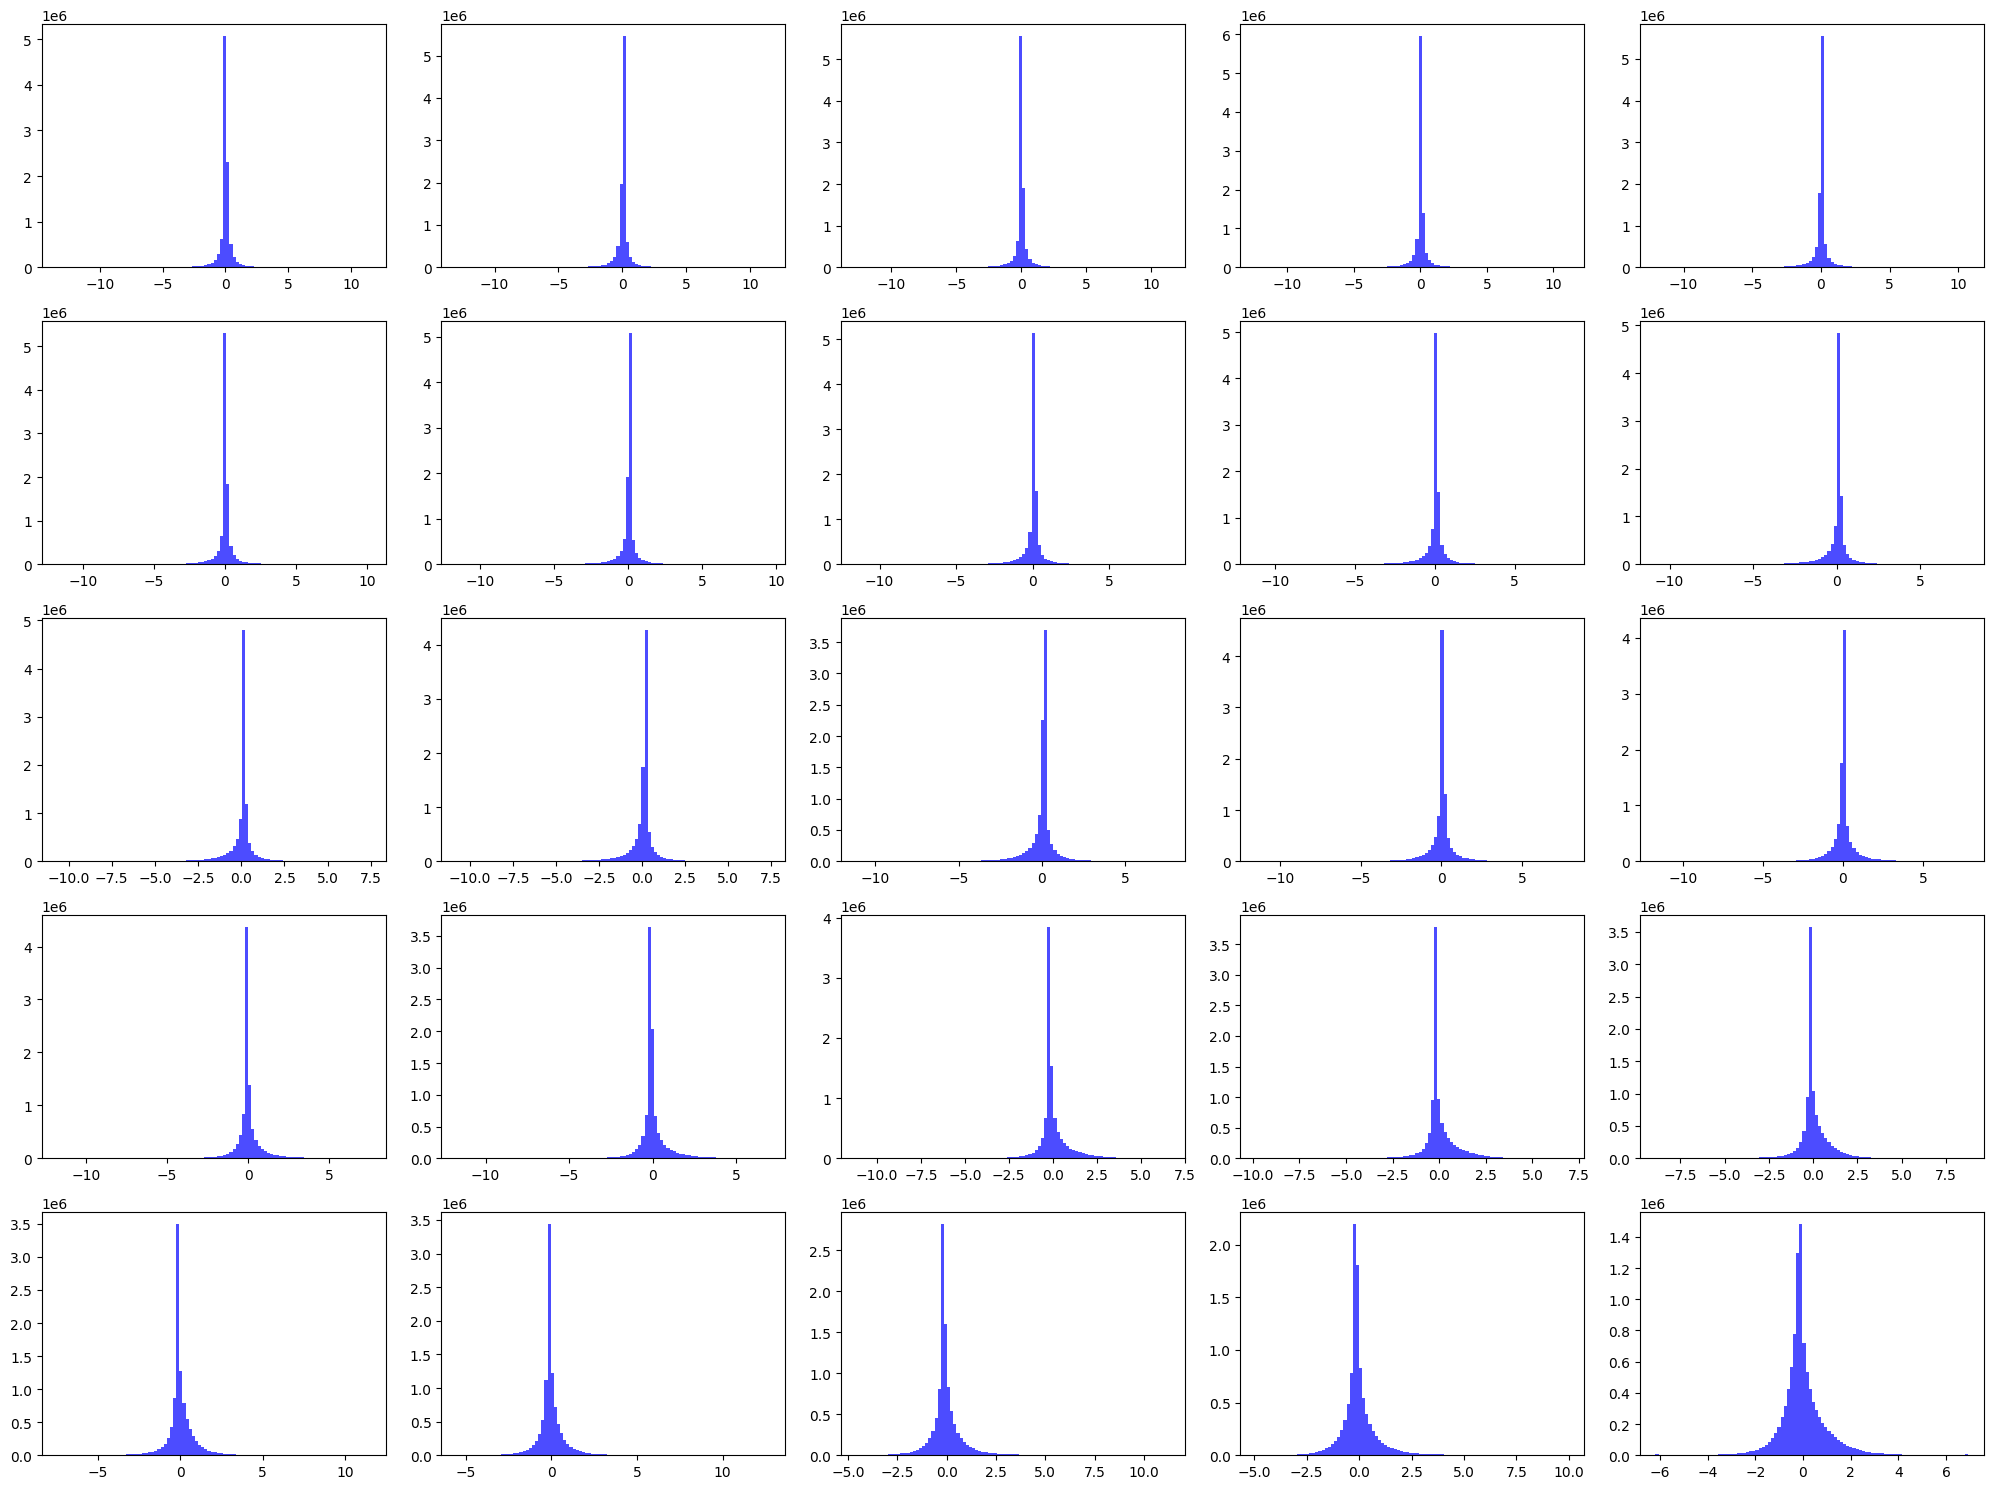

In [31]:
w = w.bool()
b = 11
fig, axs = plt.subplots(5, 5, figsize=(20, 15))
for i in range(25):
    if 25 * b + i < label.size(1) and w[25 * b + i]:
        var = label_[:,25 * b + i]
        # var = (var - var.mean()) / var.std()
        axs[i//5, i%5].hist(var.numpy(), bins=100, color='blue', alpha=0.7)
plt.tight_layout()
plt.show()

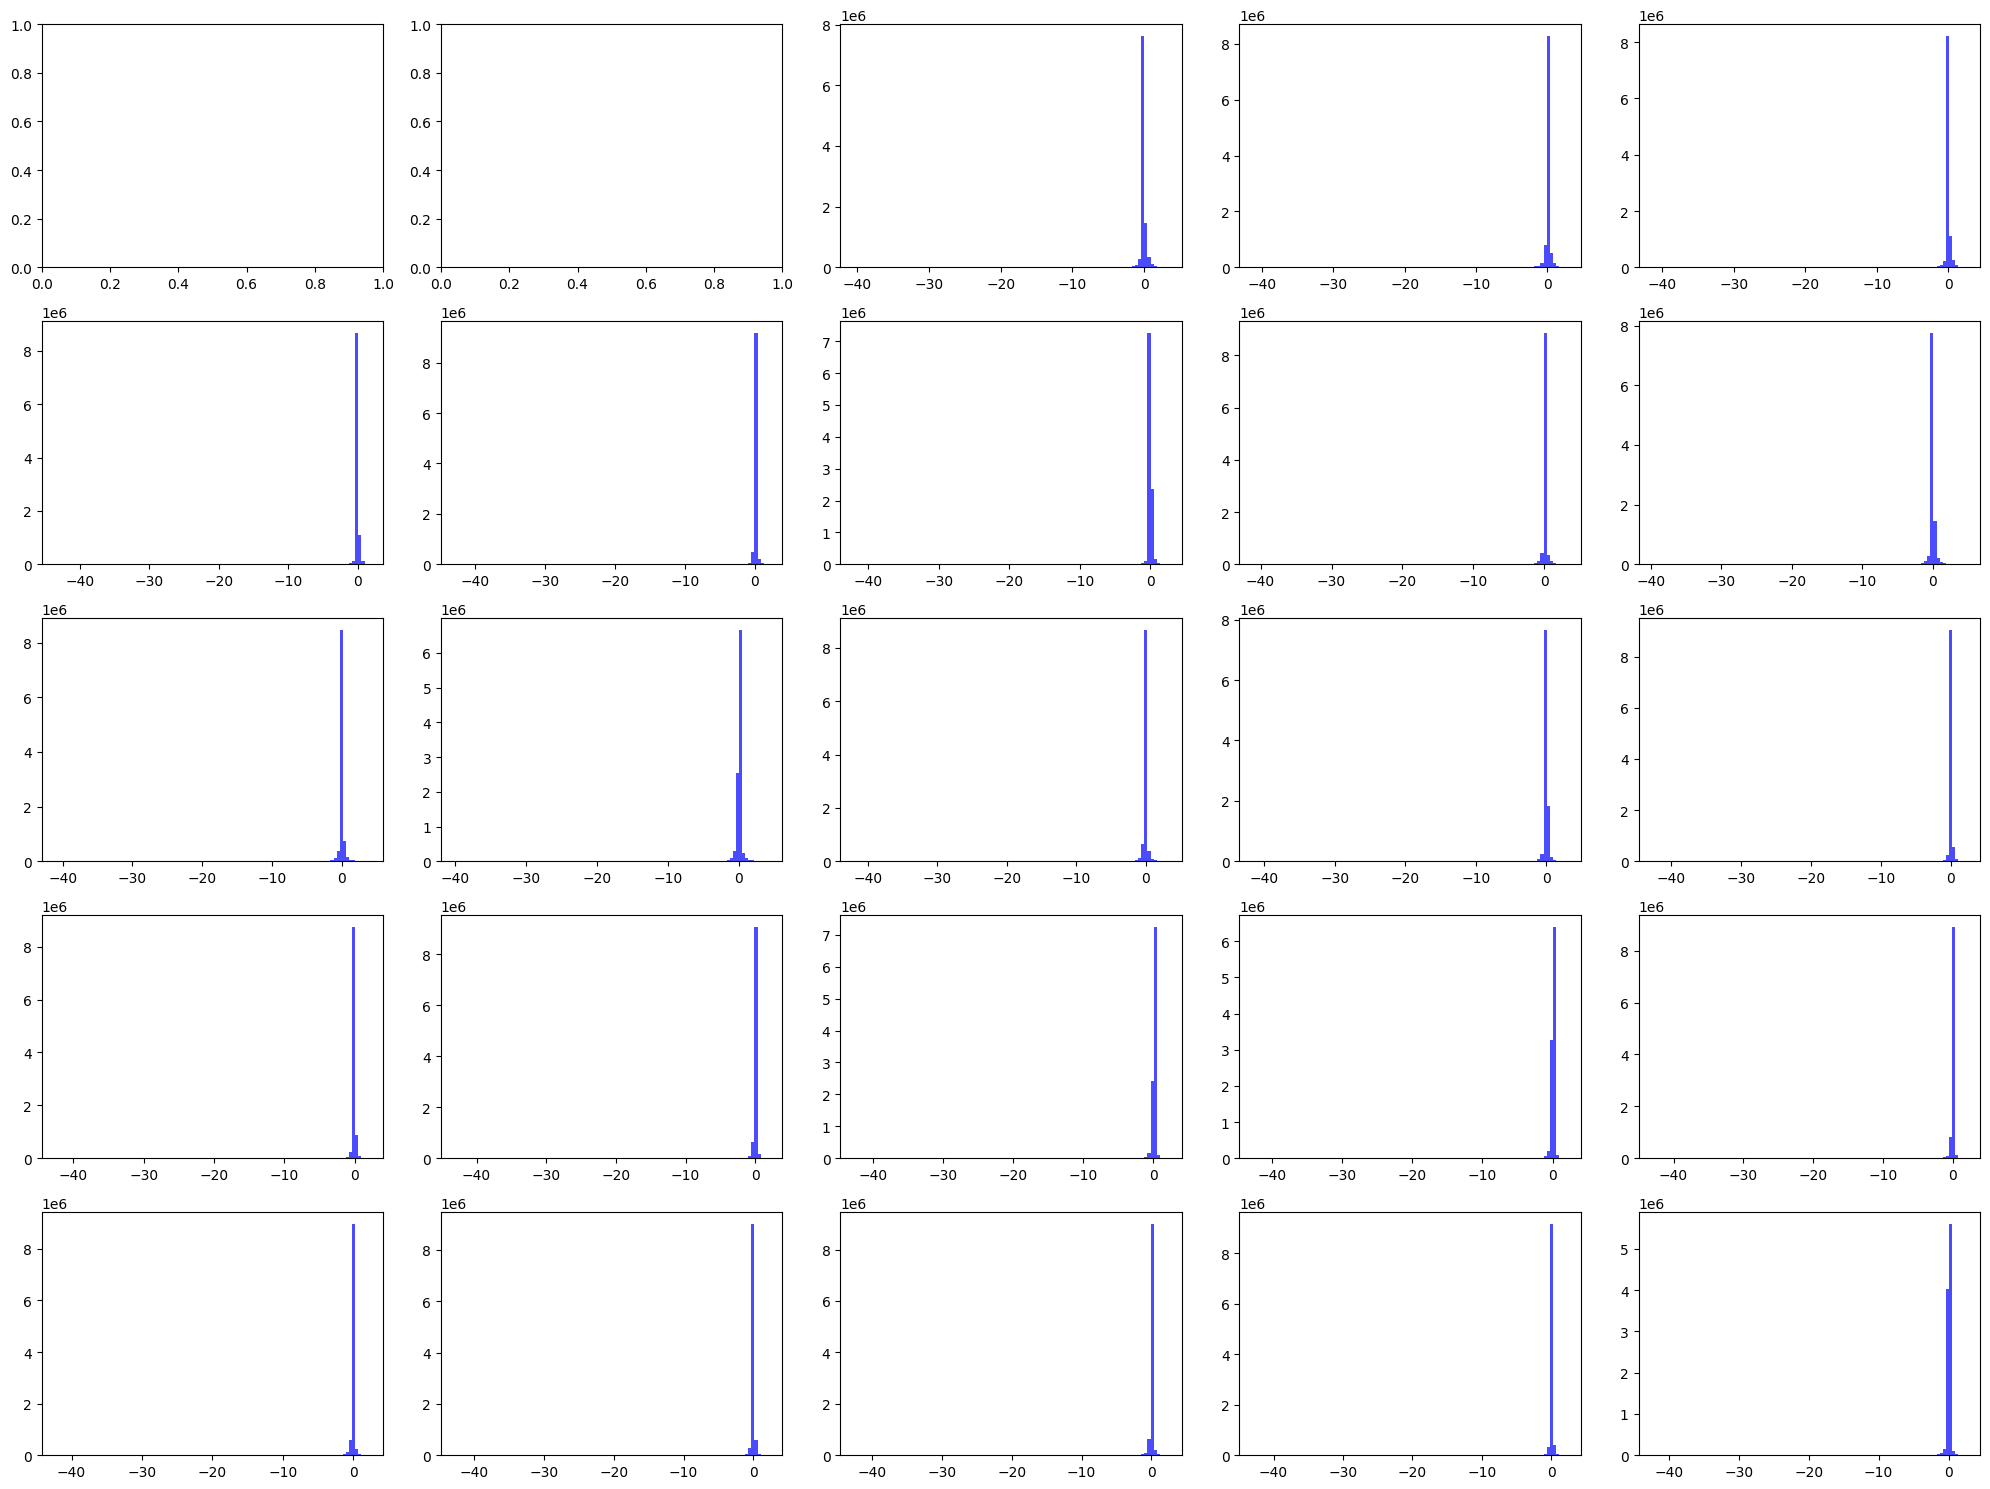

In [19]:

fig, axs = plt.subplots(5, 5, figsize=(20, 15))
for i in range(25):
    if 25 * b + i < label.size(1) and w[25 * b + i]:
        var = label_[:,25 * b + i].numpy()
        if np.min(var) < 0:
            var -= np.min(var)
        var = np.where(var>0, var, np.min(var[var>0]))
        var = np.log(var)
        if var.std() > 0:
            var = (var - var.mean()) / var.std()
        axs[i//5, i%5].hist(var, bins=100, color='blue', alpha=0.7)

plt.tight_layout()
plt.show()